<a href="https://colab.research.google.com/github/LisaBa/DeepLearning/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LeNet5
Implementing [Yann LeCun's "LeNet5" using PyTorch](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320).
LeNet5 is a 7 layer Convolutional Neural Network (CNN), trained on grayscale images of size 32x32 pixels.

![](https://miro.medium.com/max/700/1*ueA-rooOaiIo3s2rVVz3Ww.png)

In [2]:
# Import libraries
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# set parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [4]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [5]:
def train(train_loader, model, criterion, optimizer, device):
  '''Function for the training step of the training loop'''
  
  # Set model to training mode (not evaluation)
  model.train()
  running_loss = 0
  
  for X, y_true in train_loader:

    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  
  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [6]:
def validate(valid_loader, model, criterion, device):
  ''' Function for the validation step of the training loop '''

  # Set model to evaluation mode
  model.eval()
  running_loss = 0

  for X, y_true in valid_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass and record loss
    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)

  return model, epoch_loss

In [7]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  ''' Function defining the entire training loop '''

  # set objects for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # Train model
  for epoch in range(0,epochs):

    #training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    #validation
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every - 1):

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

In [8]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

# download and create the dataset
train_dataset = datasets.MNIST(root = "mnist_data", train=True, transform=transforms, download=True)
valid_dataset = datasets.MNIST(root="mnist_data", train = False, transform = transforms)

# define the data loaders
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw




Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
class LeNet5(nn.Module):

  def __init__(self, n_classes):
    super(LeNet5, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=n_classes)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [10]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

09:52:58 --- Epoch: 0	Train loss: 0.2300	Valid loss: 0.0898	Train accuracy: 97.33	Valid accuracy: 97.27
09:53:18 --- Epoch: 1	Train loss: 0.0789	Valid loss: 0.0808	Train accuracy: 97.85	Valid accuracy: 97.60
09:53:38 --- Epoch: 2	Train loss: 0.0555	Valid loss: 0.0553	Train accuracy: 98.59	Valid accuracy: 98.30
09:53:57 --- Epoch: 3	Train loss: 0.0444	Valid loss: 0.0487	Train accuracy: 98.95	Valid accuracy: 98.44
09:54:17 --- Epoch: 4	Train loss: 0.0351	Valid loss: 0.0489	Train accuracy: 99.15	Valid accuracy: 98.48
09:54:36 --- Epoch: 5	Train loss: 0.0317	Valid loss: 0.0517	Train accuracy: 99.16	Valid accuracy: 98.45
09:54:56 --- Epoch: 6	Train loss: 0.0250	Valid loss: 0.0402	Train accuracy: 99.51	Valid accuracy: 98.77
09:55:15 --- Epoch: 7	Train loss: 0.0223	Valid loss: 0.0485	Train accuracy: 99.32	Valid accuracy: 98.50
09:55:35 --- Epoch: 8	Train loss: 0.0200	Valid loss: 0.0451	Train accuracy: 99.49	Valid accuracy: 98.71
09:55:54 --- Epoch: 9	Train loss: 0.0173	Valid loss: 0.0418	Trai

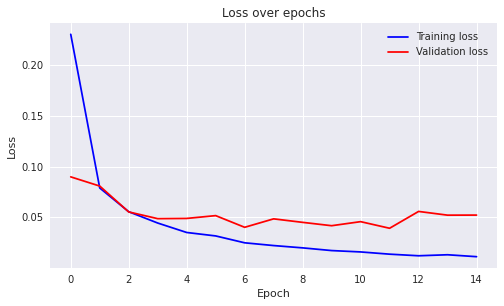

In [11]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)